# Mount to drive

In [1]:
from google.colab import drive
drive.mount('/For_Job')

Drive already mounted at /For_Job; to attempt to forcibly remount, call drive.mount("/For_Job", force_remount=True).


# Importing libraries 


In [2]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

# Setting up dataset

Download dataset for "Negative"

In [ ]:
%cd /For_Job/MyDrive/Face_Recongnition
!wget vis-www.cs.umass.edu/lfw/lfw.tgz
!tar -xf *.tgz && rm *.tgz

/For_Job/MyDrive/Face_Recongnition
--2022-06-27 05:11:30--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M  13.7MB/s    in 14s     

2022-06-27 05:11:45 (12.4 MB/s) - ‘lfw.tgz’ saved [180566744/180566744]



Setting path for "Positive", "Negative" and "Anchor"

In [4]:
POS_PATH = "/For_Job/MyDrive/Face_Recongnition/data/positive/"
NEG_PATH = "/For_Job/MyDrive/Face_Recongnition/data/negative/"
ANC_PATH = "/For_Job/MyDrive/Face_Recongnition/data/anchor/"

Copying downloaded images to "Negative" folder

In [ ]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(ANC_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

Taking 300 images to dataset for each category among all images

In [5]:
anchor = tf.data.Dataset.list_files(ANC_PATH +'*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH +'*.png').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH +'*.jpg').take(300)

Function that load each image then resize the image & scale it in between 0 to 1

In [6]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (105,105))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [7]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [8]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

Splitting train & test set

In [9]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

CNN model

In [10]:
def make_embedding(): 
    inp = Input(shape=(105,105,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [11]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

#Siamese L1 Distance class

In [12]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [13]:
input_image = Input(name='input_img', shape=(105,105,3))
validation_image = Input(name='validation_img', shape=(105,105,3))

In [14]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

# Siamese Model

In [15]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(105,105,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(105,105,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [16]:
siamese_model = make_siamese_model()

siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Loss Function

In [17]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

# Training 

In [19]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [20]:
from tensorflow.keras.metrics import Precision, Recall

def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [21]:
EPOCHS = 20
train(train_data, EPOCHS)


 Epoch 1/20
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 138s 354ms/step
0.36614278 0.11004785 1.0

 Epoch 2/20
27/27 [==============================] - 9s 327ms/step
0.19619228 0.6442308 1.0

 Epoch 3/20
27/27 [==============================] - 9s 320ms/step
0.012286123 0.94258374 1.0

 Epoch 4/20
27/27 [==============================] - 9s 324ms/step
0.020973615 0.9950495 1.0

 Epoch 5/20
27/27 [==============================] - 9s 323ms/step
0.007523254 0.97630334 1.0

 Epoch 6/20
27/27 [==============================] - 9s 313ms/step
0.08311963 0.96713614 0.9951691

 Epoch 7/20
27/27 [==============================] - 8s 310ms/step
0.04854129 1.0 1.0

 Epoch 8/20
27/27 [==============================] - 9s 318ms/step
0.008797915 1.0 1.0

 Epoch 9/20
27/27 [==============================] - 9s 324ms/step
6.1621344e-05 1.0 1.0

 Epoch 

# Save trained model

In [ ]:
siamese_model.save('/For_Job/MyDrive/Face_Recongnition/siamesemodel.h5')

# Copying images in verification for testing

In [36]:
import os
import random
import shutil


files_list = []

for root, dirs, files in os.walk("/For_Job/MyDrive/Face_Recongnition/data/positive"):
    for file in files:
        #all 
        if file.endswith(".jpg") or file.endswith(".png"):
            files_list.append(os.path.join(root, file))


#print images
#lets me count and print the amount of jpeg,jpg,pmg 
file_count = len(files_list)
print (file_count)

# print files_list   
filesToCopy = random.sample(files_list, 50)  #prints two random files from list 

destPath = "/For_Job/MyDrive/Face_Recongnition/data/application_data/verification_images"

# if destination dir does not exists, create it
if os.path.isdir(destPath) == False:
        os.makedirs(destPath)

# iteraate over all random files and move them
for file in filesToCopy:
    print(file)
    shutil.copy(file, destPath)

300
/For_Job/MyDrive/Face_Recongnition/data/positive/41.png
/For_Job/MyDrive/Face_Recongnition/data/positive/34.png
/For_Job/MyDrive/Face_Recongnition/data/positive/289.png
/For_Job/MyDrive/Face_Recongnition/data/positive/300.png
/For_Job/MyDrive/Face_Recongnition/data/positive/57.png
/For_Job/MyDrive/Face_Recongnition/data/positive/221.png
/For_Job/MyDrive/Face_Recongnition/data/positive/158.png
/For_Job/MyDrive/Face_Recongnition/data/positive/134.png
/For_Job/MyDrive/Face_Recongnition/data/positive/224.png
/For_Job/MyDrive/Face_Recongnition/data/positive/6.png
/For_Job/MyDrive/Face_Recongnition/data/positive/91.png
/For_Job/MyDrive/Face_Recongnition/data/positive/44.png
/For_Job/MyDrive/Face_Recongnition/data/positive/82.png
/For_Job/MyDrive/Face_Recongnition/data/positive/275.png
/For_Job/MyDrive/Face_Recongnition/data/positive/269.png
/For_Job/MyDrive/Face_Recongnition/data/positive/66.png
/For_Job/MyDrive/Face_Recongnition/data/positive/17.png
/For_Job/MyDrive/Face_Recongnition/da

# Verifying model with input images

In [37]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    
    for image in os.listdir(os.path.join('/For_Job/MyDrive/Face_Recongnition/data/application_data', 'verification_images')):
        input_img = preprocess(os.path.join('/For_Job/MyDrive/Face_Recongnition/data/application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('/For_Job/MyDrive/Face_Recongnition/data/application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('/For_Job/MyDrive/Face_Recongnition/data/application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [38]:
# Reload model 
siamese_model = tf.keras.models.load_model('/For_Job/MyDrive/Face_Recongnition/siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

True


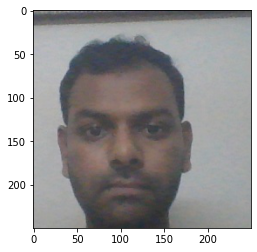

In [34]:
results, verified = verify(siamese_model, 0.8, 0.8)
image = plt.imread('/For_Job/MyDrive/Face_Recongnition/data/application_data/input_image/input_image.jpg')
plt.imshow(image)
print(verified)

False


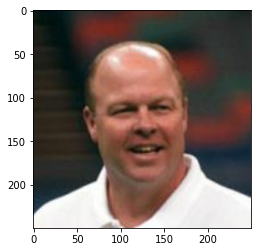

In [43]:
results, verified = verify(siamese_model, 0.8, 0.8)
image = plt.imread('/For_Job/MyDrive/Face_Recongnition/data/negative/Darrell_Dickey_0001.jpg')
plt.imshow(image)
print(verified)